In [3]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random


In [4]:

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'  # b5

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=10)

## 데이타 로드!!
batch_size  = 32
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets
data_path = 'C:/pill/pill_data3'  # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
president_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(president_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(president_dataset, train_idx)
tmp_dataset       = Subset(president_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=0)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=0)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=0)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))


224
Loaded pretrained weights for efficientnet-b0
batch_size : 32,  tvt : 535 / 67 / 67


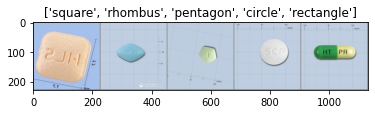

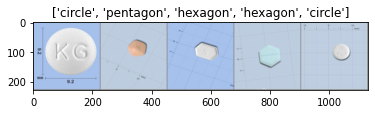

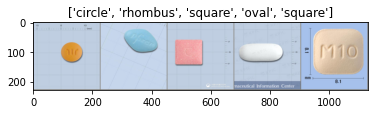

In [5]:
## 데이타 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    "0": "circle",      # "0": "원형"
    "1": "hexagon",   # "1": "육각형"
    "2": "octagon",   # "2": "팔각형"
    "3": "oval",  # "3": "타원형"
    "4": "pentagon",   # "4": "오각형"
    "5": "rectangle",   # "5": "직사각형"
    "6": "rhombus",   # "6": "마름모형"
    "7": "semicircular",   # "7": "반원형"
    "8": "square",   # "8": "정사각형"
    "9": "triangle"   # "9": "삼각형"
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [6]:
#학습 코드
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())s
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'pill_model3.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)


Epoch 0/99
----------
train Loss: 0.37 Acc: 88.0
valid Loss: 0.11 Acc: 95.6
==> best model saved - 0 / 95.6
Epoch 1/99
----------
train Loss: 0.10 Acc: 96.7
valid Loss: 0.08 Acc: 96.9
==> best model saved - 1 / 96.9
Epoch 2/99
----------
train Loss: 0.07 Acc: 97.7
valid Loss: 0.06 Acc: 97.8
==> best model saved - 2 / 97.8
Epoch 3/99
----------
train Loss: 0.05 Acc: 98.3
valid Loss: 0.04 Acc: 98.2
==> best model saved - 3 / 98.2
Epoch 4/99
----------
train Loss: 0.04 Acc: 98.5
valid Loss: 0.08 Acc: 97.1
Epoch 5/99
----------
train Loss: 0.04 Acc: 98.6
valid Loss: 0.06 Acc: 98.0
Epoch 6/99
----------
train Loss: 0.04 Acc: 98.6
valid Loss: 0.05 Acc: 98.0
Epoch 7/99
----------
train Loss: 0.04 Acc: 98.6
valid Loss: 0.04 Acc: 98.9
==> best model saved - 7 / 98.9
Epoch 8/99
----------
train Loss: 0.03 Acc: 98.9
valid Loss: 0.05 Acc: 98.3
Epoch 9/99
----------
train Loss: 0.03 Acc: 98.9
valid Loss: 0.04 Acc: 98.3
Epoch 10/99
----------
train Loss: 0.03 Acc: 99.1
valid Loss: 0.06 Acc: 98.1
Epo

Epoch 0/49
----------
train Loss: 0.13 Acc: 95.4
valid Loss: 0.21 Acc: 93.5
==> best model saved - 0 / 93.5
Epoch 1/49
----------
train Loss: 0.14 Acc: 95.4
valid Loss: 0.09 Acc: 97.0
==> best model saved - 1 / 97.0
Epoch 2/49
----------
train Loss: 0.06 Acc: 98.0
valid Loss: 0.07 Acc: 97.2
==> best model saved - 2 / 97.2
Epoch 3/49
----------
train Loss: 0.07 Acc: 97.5
valid Loss: 0.08 Acc: 97.4
==> best model saved - 3 / 97.4
Epoch 4/49
----------
train Loss: 0.04 Acc: 98.3
valid Loss: 0.06 Acc: 97.9
==> best model saved - 4 / 97.9
Epoch 5/49
----------
train Loss: 0.05 Acc: 98.2
valid Loss: 0.06 Acc: 98.1
==> best model saved - 5 / 98.1
Epoch 6/49
----------
train Loss: 0.03 Acc: 98.9
valid Loss: 0.08 Acc: 97.7
Epoch 7/49
----------
train Loss: 0.03 Acc: 98.8
valid Loss: 0.07 Acc: 97.9
Epoch 8/49
----------
train Loss: 0.03 Acc: 98.9
valid Loss: 0.05 Acc: 98.3
==> best model saved - 8 / 98.3
Epoch 9/49
----------
train Loss: 0.03 Acc: 99.0
valid Loss: 0.05 Acc: 98.3
Epoch 10/49
----

best model : 87 - 99 / 0.1


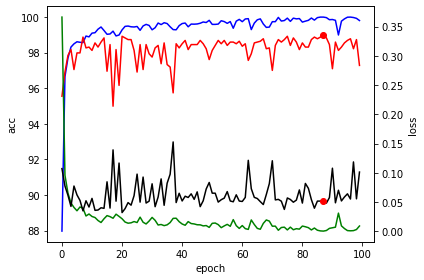

In [7]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

test done : loss/acc : 0.04 / 99.3


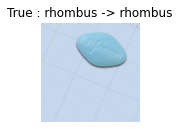

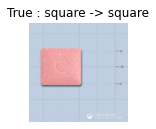

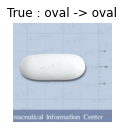

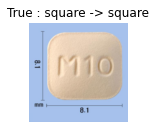

In [8]:
def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])          
            if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로
    
    ## TEST!
test_and_visualize_model(model, phase = 'test')